<a href="https://colab.research.google.com/github/OlfaHal/Master-Thesis/blob/main/GNN%2BLLM_withing_Metagraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-geometric

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
dataset_path = "/content/drive/MyDrive/Dataset/creditcard.csv"
sample_size = 50000

In [ ]:
# Load and Preprocess the Dataset
def load_and_preprocess_data(dataset_path):
    df = pd.read_csv(dataset_path)

    # Sample the data for efficiency
    #df_sample = df.sample(n=sample_size, random_state=42)

    # Split into features (X) and labels (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into training (70%), validation (15%), and testing (15%)
    X_train, X_left, y_train, y_left = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_left, y_left, test_size=0.5, random_state=42, stratify=y_left
    )

    print(f"Train Size: {X_train.shape[0]}")
    print(f"Validation Size: {X_val.shape[0]}")
    print(f"Test Size: {X_test.shape[0]}")
    print("\n")

    print("Class distribution in the original dataset:")
    print(y.value_counts())
    print("\n")
    print("Class distribution in the training dataset:")
    print(y_train.value_counts())
    print("\n")
    print("Class distribution in the validation dataset:")
    print(y_val.value_counts())


    return X, y, X_train,X_val, X_test, y_train,y_val, y_test, scaler

In [ ]:
# Load and preprocess data
X, y, X_train, X_val,  X_test, y_train, y_val, y_test, scaler = load_and_preprocess_data(dataset_path)

Train Size: 199364
Validation Size: 42721
Test Size: 42722


Class distribution in the original dataset:
Class
0    284315
1       492
Name: count, dtype: int64


Class distribution in the training dataset:
Class
0    199020
1       344
Name: count, dtype: int64


Class distribution in the validation dataset:
Class
0    42647
1       74
Name: count, dtype: int64


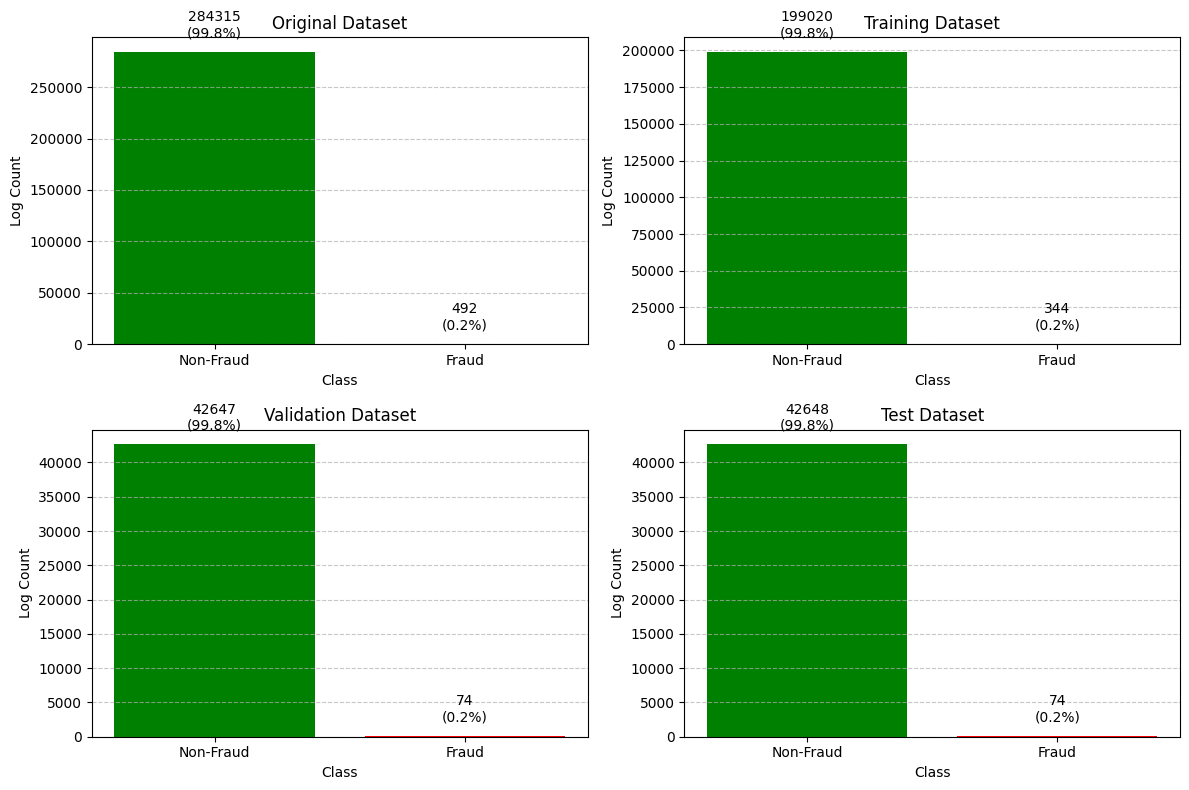

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution_with_details(data_distributions, labels, dataset_names):

    num_datasets = len(data_distributions)
    num_rows = int(np.ceil(num_datasets / 2))  # Adjust for 2 plots per row
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, (counts, dataset_name) in enumerate(zip(data_distributions, dataset_names)):
        ax = axes[i]
        total = sum(counts)
        percentages = [count / total * 100 for count in counts]
        bars = ax.bar(labels, counts, color=['green', 'red'])

        for bar, count, percentage in zip(bars, counts, percentages):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + (0.05 * max(counts)),
                f'{int(count)}\n({percentage:.1f}%)',
                ha='center',
                fontsize=10
            )

        ax.set_title(dataset_name)
        ax.set_yscale('linear')  # Set linear scale for better visualization
        ax.set_ylabel("Log Count")
        ax.set_xlabel("Class")
        ax.grid(axis='y', linestyle='--', alpha=0.7)


    for j in range(num_datasets, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

original_counts = y.value_counts()
train_counts = y_train.value_counts()
val_counts = y_val.value_counts()
test_counts = y_test.value_counts()

data_distributions = [original_counts, train_counts, val_counts, test_counts]
labels = ['Non-Fraud', 'Fraud']
dataset_names = ['Original Dataset', 'Training Dataset', 'Validation Dataset', 'Test Dataset']

plot_class_distribution_with_details(data_distributions, labels, dataset_names)


In [ ]:
y.value_counts()

,count
Class,
0,284315
1,492


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
import numpy as np

def balance_with_smote(X, y):

    # Apply SMOTE to oversample the minority class
    smote = SMOTE(sampling_strategy=0.3, random_state=42)  # 30% fraud cases
    X_smote, y_smote = smote.fit_resample(X, y)
    print(f"Class distribution after SMOTE: {y_smote.value_counts()}")

    # Apply SMOTEENN to clean noisy samples
    smote_enn = SMOTEENN(sampling_strategy=0.4, random_state=42)  # 40% fraud cases
    X_resampled, y_resampled = smote_enn.fit_resample(X_smote, y_smote)
    print(f"Class distribution after SMOTEENN: {y_resampled.value_counts()}")

    return X_resampled, y_resampled

In [ ]:
X_train_resampled , y_train_resampled = balance_with_smote(X_train, y_train)

Class distribution after SMOTE: Class
0    199020
1     59706
Name: count, dtype: int64
Class distribution after SMOTEENN: Class
0    198684
1     79608
Name: count, dtype: int64


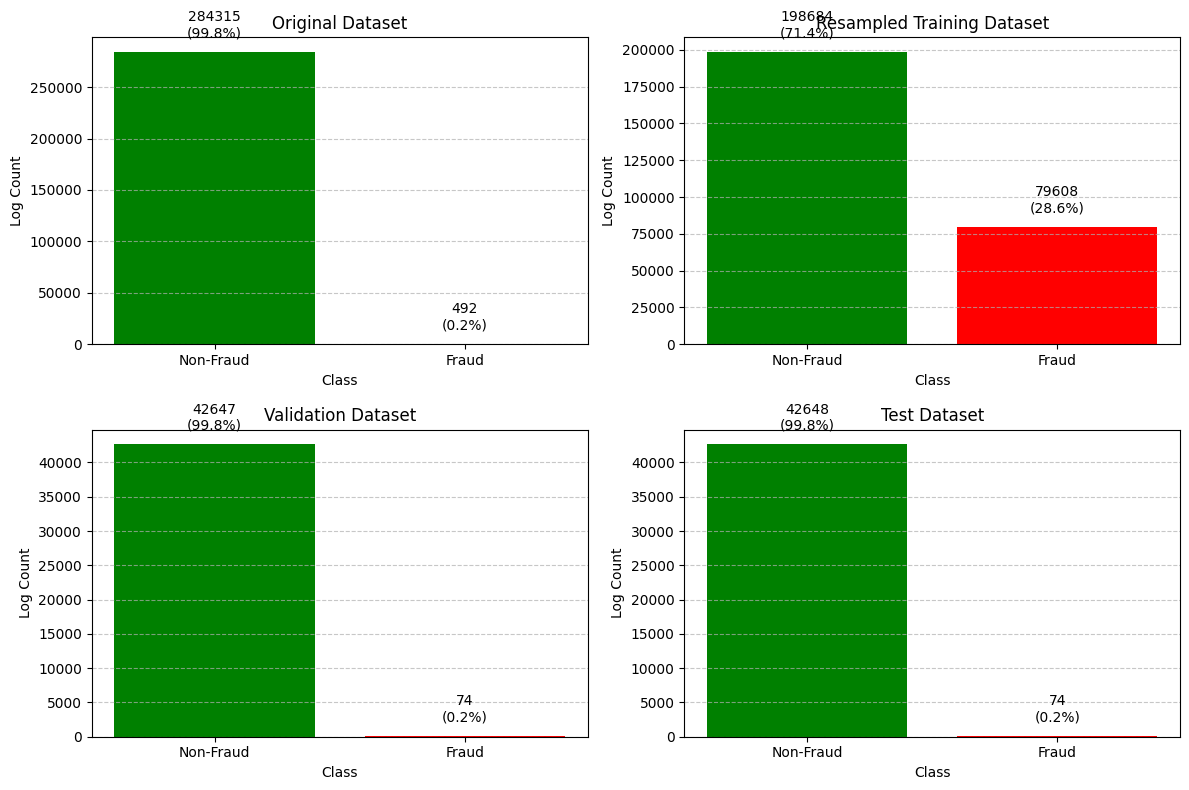

In [ ]:
#Visualize Resampled Training Dataset
original_counts = y.value_counts()
train_resampled_counts = y_train_resampled.value_counts()
val_counts = y_val.value_counts()
test_counts = y_test.value_counts()

data_distributions = [original_counts, train_resampled_counts, val_counts, test_counts]
labels = ['Non-Fraud', 'Fraud']
dataset_names = ['Original Dataset', 'Resampled Training Dataset', 'Validation Dataset', 'Test Dataset']

plot_class_distribution_with_details(data_distributions, labels, dataset_names)

In [ ]:
# Create Graph Data (KNN Edges)
def create_knn_edges(features, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(features)
    _, indices = nbrs.kneighbors(features)

    edges = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edges.append((i, neighbor))

    return torch.tensor(edges, dtype=torch.long).t()

#The shape is (2, num_edges), where:
#Row 0 contains source nodes.
#Row 1 contains target nodes.

In [ ]:
edge_index_train = create_knn_edges(X_train)

In [ ]:
def create_graph_data(X, y, k=5):

    edge_index = create_knn_edges(X, k)
    return Data(
        x=torch.tensor(X, dtype=torch.float),
        edge_index=edge_index,
        y=torch.tensor(y.values, dtype=torch.long)
    )


In [ ]:
# Define GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, embedding_dim):

        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, embedding_dim)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [ ]:
# Train GNN Model
def train_gnn(data, model, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        output = model(data.x, data.edge_index)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            logits = model(data.x, data.edge_index)
            preds = torch.argmax(logits, dim=1)
            accuracy = accuracy_score(data.y.cpu(), preds.cpu())
            f1 = f1_score(data.y.cpu(), preds.cpu(), average="weighted")
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    return model

In [ ]:
!pip install faiss-cpu


In [ ]:
import faiss
#Metagraph generation with Faiss is cost effective
def generate_metagraph_with_faiss(embeddings, k=5):
    index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 distance metric
    index.add(embeddings.cpu().numpy())  # Add embeddings
    distances, indices = index.search(embeddings.cpu().numpy(), k)

    edges = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edges.append((i, neighbor))

    return torch.tensor(edges, dtype=torch.long).t()


In [ ]:
#  Visualize Graph
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(edge_index, num_nodes, title="Graph"):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edge_index.t().tolist())
    plt.figure(figsize=(10, 10))
    nx.draw(G, node_size=10, edge_color="blue")
    plt.title(title)
    plt.show()

In [ ]:
# Create graph data
train_data = create_graph_data(X_train, y_train)
val_data = create_graph_data(X_val, y_val)
test_data = create_graph_data(X_test, y_test)


In [ ]:
train_data.x.shape

torch.Size([199364, 30])

In [ ]:
# Initialize and train the GNN
num_features = train_data.x.shape[1]
hidden_channels = 64
embedding_dim = 32


gnn_model = GNNModel(num_features=num_features, hidden_channels=hidden_channels, embedding_dim=embedding_dim)


trained_gnn = train_gnn(train_data, gnn_model)

Epoch 1, Loss: 3.4073, Accuracy: 0.3796, F1: 0.5500
Epoch 2, Loss: 2.7804, Accuracy: 0.7787, F1: 0.8742
Epoch 3, Loss: 2.1985, Accuracy: 0.9686, F1: 0.9824
Epoch 4, Loss: 1.6898, Accuracy: 0.9976, F1: 0.9971
Epoch 5, Loss: 1.2665, Accuracy: 0.9983, F1: 0.9974
Epoch 6, Loss: 0.9289, Accuracy: 0.9983, F1: 0.9974
Epoch 7, Loss: 0.6690, Accuracy: 0.9983, F1: 0.9974
Epoch 8, Loss: 0.4744, Accuracy: 0.9983, F1: 0.9974
Epoch 9, Loss: 0.3319, Accuracy: 0.9983, F1: 0.9974
Epoch 10, Loss: 0.2297, Accuracy: 0.9983, F1: 0.9974
Epoch 11, Loss: 0.1578, Accuracy: 0.9983, F1: 0.9974
Epoch 12, Loss: 0.1083, Accuracy: 0.9983, F1: 0.9974
Epoch 13, Loss: 0.0747, Accuracy: 0.9983, F1: 0.9976
Epoch 14, Loss: 0.0521, Accuracy: 0.9985, F1: 0.9981
Epoch 15, Loss: 0.0372, Accuracy: 0.9987, F1: 0.9984
Epoch 16, Loss: 0.0275, Accuracy: 0.9989, F1: 0.9987
Epoch 17, Loss: 0.0212, Accuracy: 0.9990, F1: 0.9989
Epoch 18, Loss: 0.0170, Accuracy: 0.9991, F1: 0.9989
Epoch 19, Loss: 0.0143, Accuracy: 0.9991, F1: 0.9990
Ep

In [ ]:
# Generate embeddings for the training dataset
gnn_model.eval()
with torch.no_grad():
    train_embeddings = gnn_model(train_data.x, train_data.edge_index)


In [ ]:
train_embeddings.shape

torch.Size([199364, 32])

In [ ]:
# Generate embeddings for the test dataset
with torch.no_grad():
    test_embeddings = gnn_model(test_data.x, test_data.edge_index)

In [ ]:
# Visualization
def visualize_embeddings(embeddings, labels,title):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="coolwarm", s=5)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Fraud Label")
    plt.show()

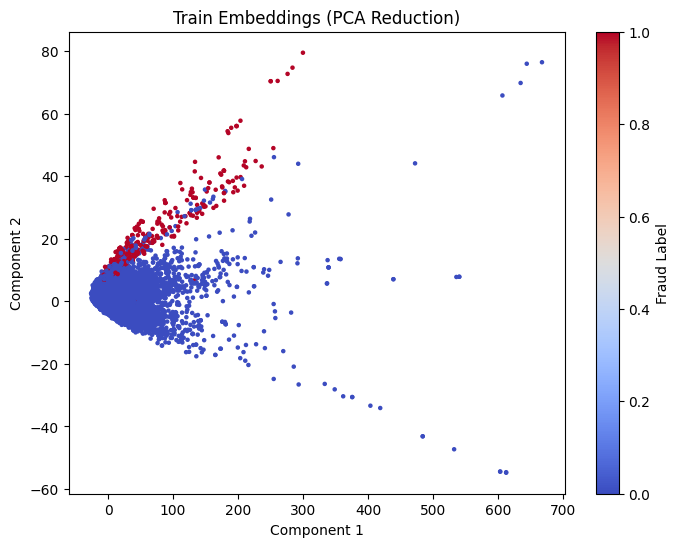

In [ ]:
visualize_embeddings(train_embeddings.numpy(), y_train, "Train Embeddings (PCA Reduction)")

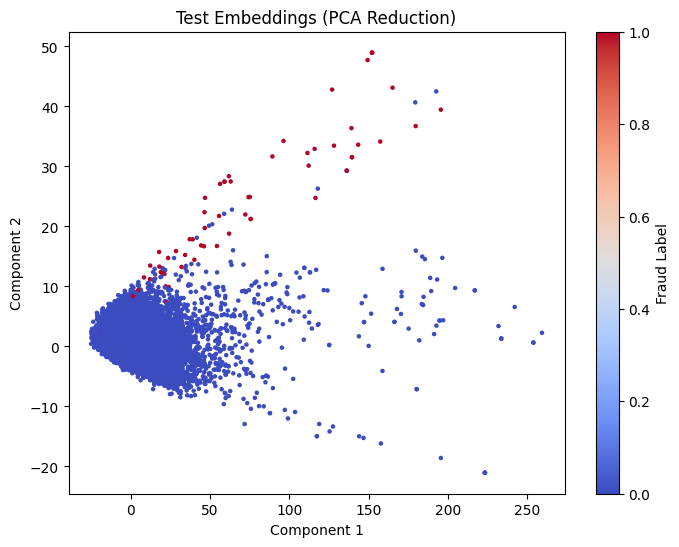

In [ ]:
visualize_embeddings(test_embeddings.numpy(), y_test, "Test Embeddings (PCA Reduction)")

In [ ]:
train_data_resampled = create_graph_data(X_train_resampled, y_train_resampled)

In [ ]:
with torch.no_grad():
    train_embeddings_resampled = gnn_model(train_data_resampled.x, train_data_resampled.edge_index)

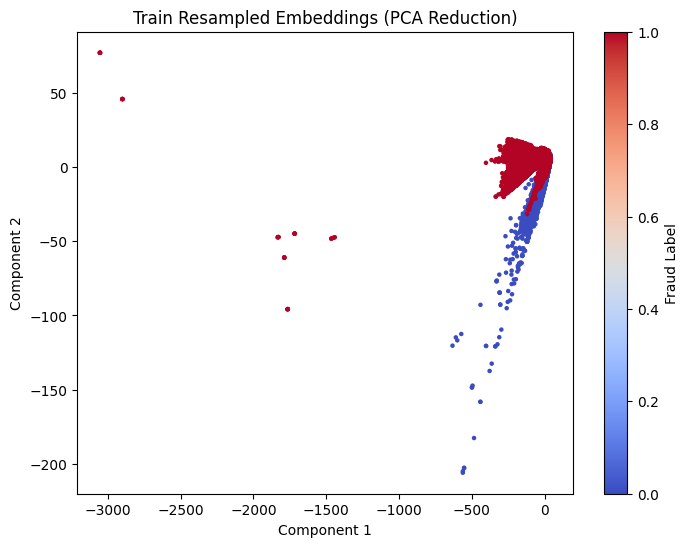

In [ ]:
visualize_embeddings(train_embeddings_resampled.numpy(), y_train_resampled, "Train Resampled Embeddings (PCA Reduction)")

In [ ]:
batch_size = 1000  # Process 1000 embeddings at a time
edges = []

for i in range(0, train_embeddings.size(0), batch_size):
    batch_embeddings = train_embeddings[i : i + batch_size]
    batch_edges = generate_metagraph_with_faiss(batch_embeddings)
    edges.append(batch_edges)

    # Save edges after every batch
    torch.save(edges, f"metagraph_edges_batch_{i // batch_size}.pt")

# Combine edges after the loop
metagraph_edges = torch.cat(edges, dim=1)

torch.save(metagraph_edges, "metagraph_edges.pt")


In [ ]:
metagraph_edges.shape

torch.Size([2, 797456])

In [ ]:
metagraph_edges

tensor([[  0,   0,   0,  ..., 363, 363, 363],
        [ 90, 263, 857,  ..., 169, 158,  61]])

Metagraph Evaluation lasts more than one hour!!!

In [ ]:
# Visualize the metagraph
#visualize_graph(metagraph_edges, train_embeddings.shape[0], title="Metagraph") #lasts more than one hour!!!

**GNN Model Testing**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch

def test_gnn(model, test_data):

    model.eval()

    with torch.no_grad():

        logits = model(test_data.x, test_data.edge_index)
        predictions = torch.argmax(logits, dim=1)

        # Calculate metrics
        accuracy = accuracy_score(test_data.y.cpu(), predictions.cpu())
        f1 = f1_score(test_data.y.cpu(), predictions.cpu(), average="weighted", zero_division=0)
        precision = precision_score(test_data.y.cpu(), predictions.cpu(), average="weighted", zero_division=0)
        recall = recall_score(test_data.y.cpu(), predictions.cpu(), average="weighted", zero_division=0)

        metrics = {
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall
        }

    return predictions, metrics


In [ ]:
# Prepare test data as a PyTorch Geometric Data object
test_data = create_graph_data(X_test, y_test)

# Test the GNN model
predictions, test_metrics = test_gnn(trained_gnn, test_data)

# Print test metrics
print("Test Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Test Metrics:
Accuracy: 0.9993
F1 Score: 0.9993
Precision: 0.9993
Recall: 0.9993


In [ ]:
predictions.shape

torch.Size([42722])

In [ ]:
count = (predictions == 1).sum().item()
print("Predictions have " ,count , "Fraud")

Predictions have  54 Fraud


In [ ]:
count1 = (y_test == 1).sum().item()
print("Test Data have " ,count1 , "Fraud")

Test Data have  74 Fraud


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_data.y.cpu(), predictions.cpu(), target_names=["Non-Fraud", "Fraud"]))


              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     42648
       Fraud       0.93      0.68      0.78        74

    accuracy                           1.00     42722
   macro avg       0.96      0.84      0.89     42722
weighted avg       1.00      1.00      1.00     42722



In [ ]:
test_data.x.shape

torch.Size([42722, 30])

In [ ]:
y_test.value_counts()

,count
Class,
0,42648
1,74


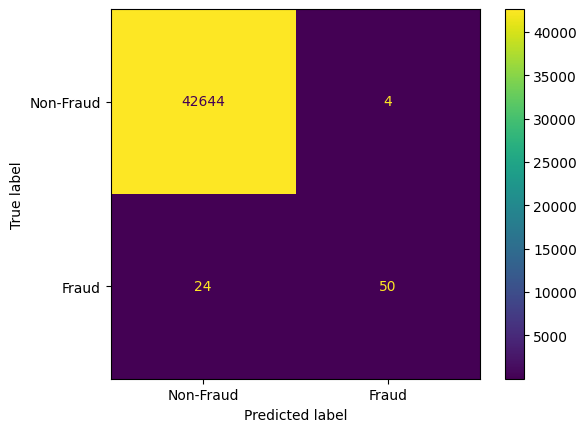

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_data.y.cpu(), predictions.cpu(), display_labels=["Non-Fraud", "Fraud"])
plt.show()


----------------------------------------
**Integrating LLM**
----------------------------------------

In [ ]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [ ]:
# LLM-Layer: Generate LLM Embeddings
def generate_llm_embeddings(llm, tokenizer, transactions, batch_size=128):
    llm.eval()
    embeddings = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    llm = llm.to(device)

    for i in range(0, len(transactions), batch_size):
        batch_text = [f"Transaction: {t.tolist()}" for t in transactions[i:i + batch_size]]
        tokenized_inputs = tokenizer(batch_text, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = llm(**tokenized_inputs)
        # Pool embeddings
        pooled_embeddings = outputs.last_hidden_state.mean(dim=1).cpu()
        embeddings.append(pooled_embeddings)
    return torch.cat(embeddings, dim=0)


In [ ]:
# Fusion Layer: Combine GNN + LLM Embeddings
class FusionLayer(nn.Module):
    def __init__(self, gnn_dim, llm_dim, fusion_dim):
        super(FusionLayer, self).__init__()
        self.fc = nn.Linear(gnn_dim + llm_dim, fusion_dim)

    def forward(self, gnn_embeddings, llm_embeddings):
        combined = torch.cat([gnn_embeddings, llm_embeddings], dim=1)  # Concatenate
        return self.fc(combined)

In [ ]:
# Classification Layer
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [ ]:
import torch

def train_classifier(embeddings, labels, classifier, epochs=10, batch_size=32):

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters())

    # Convert embeddings to a PyTorch tensor and move to the device
    embeddings = torch.tensor(embeddings, device=next(classifier.parameters()).device)

    for epoch in range(epochs):
        for i in range(0, len(embeddings), batch_size):
            # Get batch of embeddings and labels
            batch_embeddings = embeddings[i:i + batch_size]
            batch_labels = labels[i:i + batch_size].to(next(classifier.parameters()).device)

            optimizer.zero_grad()
            outputs = classifier(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    return classifier



In [ ]:
# Model Evaluation
def evaluate_model(classifier, embeddings, labels):
    classifier.eval()
    with torch.no_grad():
        logits = classifier(embeddings)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()

    labels = labels.cpu().numpy()
    print(classification_report(labels, predictions))
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")


In [ ]:
train_embeddings

tensor([[  9.4892,  -3.5380,  -6.7777,  ...,  -5.7716,  -5.8996,  -7.6439],
        [  6.4644,  -1.2612,  -4.1904,  ...,  -4.2484,  -3.8510,  -4.3172],
        [ 12.5042,  -1.4423,  -8.9193,  ..., -11.7793,  -8.0619, -10.1907],
        ...,
        [ 13.3577,  -1.5467,  -9.8467,  ..., -10.0961,  -7.4838, -10.5885],
        [  8.0717,  -2.0353,  -6.8129,  ...,  -6.5071,  -5.4276,  -6.3030],
        [  7.8248,  -1.7353,  -5.8454,  ...,  -6.0639,  -4.3894,  -6.8443]])

In [ ]:
test_embeddings

tensor([[  7.9626,  -3.5206,  -4.9456,  ...,  -5.7556,  -5.2243,  -7.9190],
        [ 17.0922,  -3.4451, -12.1006,  ..., -11.2364,  -8.2641, -13.9495],
        [  7.2061,  -2.1802,  -6.3576,  ...,  -5.3403,  -5.2650,  -5.5885],
        ...,
        [ 10.1483,  -3.3807,  -9.3176,  ...,  -9.4474,  -6.9096,  -7.9960],
        [  8.5709,  -1.7355,  -5.9194,  ...,  -6.7167,  -5.6173,  -6.7940],
        [ 10.1142,  -4.7908,  -6.4574,  ...,  -6.5389,  -7.0596,  -7.8288]])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
llm = AutoModel.from_pretrained("distilbert-base-uncased")

In [ ]:
test_data.x

tensor([[ 1.1322e+00, -5.5578e-01,  1.3788e-01,  ..., -2.9837e-01,
          1.5648e-02, -1.1334e-01],
        [-1.1043e+00, -4.7692e+00,  4.5194e+00,  ...,  3.1754e+00,
         -1.1262e+00, -3.1385e-01],
        [-3.4760e-01, -1.7442e-01,  6.6398e-01,  ...,  5.9973e-01,
          2.9480e-01, -3.3380e-01],
        ...,
        [ 4.7934e-01,  1.1043e+00, -1.1322e+00,  ...,  9.0628e-02,
         -1.2618e-01, -8.1360e-02],
        [-1.1880e+00,  7.1162e-01, -3.1283e-01,  ..., -7.0024e-02,
         -3.4776e-03, -6.5367e-02],
        [ 1.0087e+00,  1.0322e+00, -3.7053e-02,  ..., -4.8322e-02,
         -2.0217e-01, -3.4923e-01]])

In [ ]:
train_llm_embeddings = generate_llm_embeddings(llm, tokenizer, train_data.x[:1000])



In [ ]:
print(train_llm_embeddings.shape)
train_llm_embeddings

torch.Size([1000, 768])


tensor([[-0.3257,  0.2540,  0.5986,  ..., -0.0986, -0.0774, -0.2127],
        [-0.2932,  0.2065,  0.5741,  ..., -0.1376, -0.0539, -0.1826],
        [-0.3871,  0.2084,  0.5202,  ..., -0.0876, -0.0637, -0.2392],
        ...,
        [-0.3358,  0.2380,  0.5568,  ..., -0.1204, -0.0445, -0.2092],
        [-0.3160,  0.2034,  0.6002,  ..., -0.0762, -0.0557, -0.2021],
        [-0.4120,  0.2449,  0.5621,  ..., -0.0976, -0.0560, -0.2117]])

**Fusion Layer**

In [ ]:
fusion_layer = FusionLayer(gnn_dim=train_embeddings.size(1),
                           llm_dim=train_llm_embeddings.size(1),
                           fusion_dim=128)

In [ ]:
train_embeddings_subset1000 = train_embeddings[:1000]

In [ ]:
train_combined_embeddings = fusion_layer(train_embeddings_subset1000, train_llm_embeddings)

In [ ]:
train_combined_embeddings.shape

torch.Size([1000, 128])

In [ ]:
y_train.shape

(199364,)

In [ ]:
y_train_tensor = torch.tensor(y_train.values)

In [ ]:
classifier = Classifier(input_dim=128, num_classes=2)
trained_classifier = train_classifier(train_combined_embeddings, y_train_tensor[:1000], classifier)


<ipython-input-154-4bce1825ad54>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(embeddings, device=next(classifier.parameters()).device)


In [ ]:
test_llm_embeddings = generate_llm_embeddings(llm, tokenizer, test_data.x[:10000])

In [ ]:
test_embeddings_subset10000 = test_embeddings[:10000]

In [ ]:
test_combined_embeddings = fusion_layer(test_embeddings_subset10000, test_llm_embeddings)

In [ ]:
def evaluate_model(model, embeddings, labels):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode


    embeddings = torch.tensor(embeddings, dtype=torch.float32, device=device)
    labels = torch.tensor(labels.values if isinstance(labels, pd.Series) else labels, dtype=torch.long, device=device)

    with torch.no_grad():
        outputs = model(embeddings)
        predictions = torch.argmax(outputs, dim=1)


    labels_cpu = labels.cpu()
    predictions_cpu = predictions.cpu()


    accuracy = accuracy_score(labels_cpu, predictions_cpu)
    precision = precision_score(labels_cpu, predictions_cpu, average="weighted", zero_division=0)
    recall = recall_score(labels_cpu, predictions_cpu, average="weighted", zero_division=0)
    f1 = f1_score(labels_cpu, predictions_cpu, average="weighted", zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return predictions_cpu


In [ ]:
predictions_llm_gnn = evaluate_model(trained_classifier, test_combined_embeddings, y_test[:10000])

Accuracy: 0.9980
Precision: 0.9960
Recall: 0.9980
F1 Score: 0.9970


<ipython-input-163-08031b15fb53>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(embeddings, dtype=torch.float32, device=device)


In [ ]:
predictions_llm_gnn
count = (predictions_llm_gnn == 1).sum().item()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(labels, predictions, class_names):

    # Generate the confusion matrix
    cm = confusion_matrix(labels, predictions)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return cm


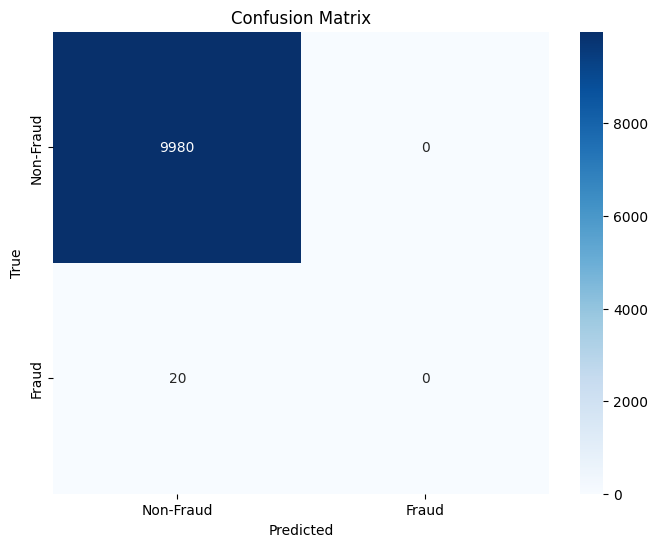

In [ ]:
confusion_matrix_results = plot_confusion_matrix(y_test[:10000], predictions_llm_gnn, class_names=["Non-Fraud", "Fraud"])


----------------------------------------------

--------------------------------------------

---------------------------------------
**GNN Model Inference**
---------------------------------------

In [ ]:
# Predict a new transaction
transaction = [472,-3.043540624,-3.157307121,1.08846278,2.288643618,1.35980513,-1.064822523,0.325574266,-0.067793653,-0.270952836,-0.838586565,-0.414575448,-0.50314086,0.676501545,-1.692028933,2.000634839,0.666779696,0.599717414,1.725321007,0.28334483,2.102338793,0.661695925,0.435477209,1.375965743,-0.293803153,0.279798032,-0.145361715,-0.252773123,0.035764225,529]
# Replace with real transaction data
transaction_embedding = predict_transaction(transaction, trained_gnn, scaler, test_data)

**Implement SHAP**


In [ ]:
!pip install shap


In [ ]:
import shap
from torch_geometric.utils import subgraph

def explain_with_shap(model, data, feature_names, num_samples=100):

    # Sample a subset of nodes for explanation
    sampled_indices = torch.randperm(data.x.shape[0])[:num_samples]
    sampled_features = data.x[sampled_indices]
    sampled_labels = data.y[sampled_indices]

    def model_predict(x):

        predictions = []
        for i, features in enumerate(x):
            # Create a subgraph for the node being explained
            node_idx = sampled_indices[i]
            subset, sub_edge_index = subgraph(
                torch.tensor([node_idx]), data.edge_index, relabel_nodes=True, num_nodes=data.x.size(0)
            )


            if sub_edge_index is None or sub_edge_index.numel() == 0:
                predictions.append(torch.zeros((1, model.fc.out_features)).numpy())
                continue

            sub_edge_index = sub_edge_index.long()

            sub_x = data.x[subset]

            with torch.no_grad():
                model.eval()
                output = model(sub_x, sub_edge_index)
                predictions.append(output[0].detach().numpy())  # Output for the explained node
        return torch.tensor(predictions)

    explainer = shap.KernelExplainer(model_predict, sampled_features.numpy())

    shap_values = explainer.shap_values(sampled_features.numpy())

    shap.summary_plot(shap_values, sampled_features.numpy(), feature_names=feature_names)

    return shap_values



**Implement LIME**


In [ ]:
!pip install lime

In [ ]:
from lime import lime_tabular
import numpy as np

def explain_with_lime(model, data, feature_names, num_samples=100, class_names=["Non-Fraud", "Fraud"]):

    sampled_indices = torch.randperm(data.x.shape[0])[:num_samples]
    sampled_features = data.x[sampled_indices].numpy()
    sampled_labels = data.y[sampled_indices].numpy()

    def model_predict(x):
      predictions = []
      for i in range(x.shape[0]):
          sub_edge_index, _ = subgraph(
                  [i], data.edge_index, relabel_nodes=True
              )
          if sub_edge_index is None or sub_edge_index.numel() == 0:

              num_output_features = 2

              predictions.append(torch.zeros((1, num_output_features)).numpy())
              continue
          with torch.no_grad():
              model.eval()

              output = model(x[i].unsqueeze(0), sub_edge_index)

              predictions.append(output.softmax(dim=1).detach().numpy())
      return np.vstack(predictions)

In [ ]:
feature_names = [f"V{i+1}" for i in range(train_data_resampled.x.shape[1])]

In [ ]:
feature_names

In [ ]:
shap_values = explain_with_shap(trained_gnn, train_data, feature_names, num_samples=100)


In [ ]:
trained_gnn

In [ ]:
train_data

In [ ]:
lime_explanation = explain_with_lime(trained_gnn, train_data, feature_names)

In [ ]:
print(lime_explanation)